# Load data

In [1]:
from pathlib import Path
from datasets import DatasetDict


dataName = "blanchon/EuroSAT_RGB"
dataPath = Path(dataName)
if dataPath.exists() is False:
    from datasets import load_dataset

    ds: DatasetDict = load_dataset(dataName)  # type: ignore
    ds.save_to_disk(dataPath)  # type: ignore

else:
    from datasets import load_from_disk

    ds: DatasetDict = load_from_disk(dataPath)  # type: ignore


print(ds)

/home/tu/micromamba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})


A look at some images

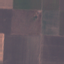

In [2]:
ds["train"][0]["image"]

In [3]:
ds["train"][16199]["label"]

9

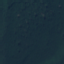

In [4]:
ds["test"][900]["image"]

The properties of the images

In [5]:
img = ds["train"][0]["image"]

print(f"Size = {img.size}")
print(f"Mode = {img.mode}")
print(f"Format = {img.format}")

Size = (64, 64)
Mode = RGB
Format = PNG


# Dataset

Prepare data for training and evaluating.

Also augment the train data by introduce random effects like cropting, rotating, flip.

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torchvision.transforms import functional as ImgF


# ds["train"][0]["image"] is a PIL.JpegImagePlugin.JpegImageFile
class ImageDataset(Dataset):
    """Dataset of images and its labels. Return image and label. If transform is provided, apply it to the image.

    Args:
        Dataset (_type_): _description_
    """

    IMG_SIZE = 64, 64

    def transformBuild(self):
        transformations = []
        transformations.append(v2.Resize(size=ImageDataset.IMG_SIZE))
        if self.randCrop:
            transformations.append(
                v2.RandomResizedCrop(size=ImageDataset.IMG_SIZE, scale=(0.8, 1.0))
            )
        if self.randRot:
            transformations.append(v2.RandomRotation(15))  # type: ignore
        if self.randFlipH:
            transformations.append(v2.RandomHorizontalFlip())
        if self.randFlipV:
            transformations.append(v2.RandomVerticalFlip())

        transformations.append(v2.ToImage())
        transformations.append(v2.ToDtype(torch.float32, True))
        
        transformations.append(self.normaliser)

        return v2.Compose(transformations)

    def __init__(
        self,
        data,
        randCrop=False,
        randRot=False,
        randFlipH=False,
        randFlipV=False,
        normaliser=None,
    ):
        self.randCrop = randCrop
        self.randRot = randRot
        self.randFlipH = randFlipH
        self.randFlipV = randFlipV

        self.length = len(data)
        self.imgSize = self.IMG_SIZE

        self.images = [d["image"] for d in data]
        self.labels = [d["label"] for d in data]

        # calculate normaliser if not provided
        if normaliser is None:
            c = ImgF.to_tensor(self.images[0]).size(0)
            mean = torch.zeros(c)
            std = torch.zeros(c)

            for img in self.images:
                img = ImgF.to_tensor(img)
                mean += img.mean(dim=(1, 2))
                std += img.std(dim=(1, 2))

            mean /= self.length
            std /= self.length

            normaliser = v2.Normalize(mean.tolist(), std.tolist())
        self.normaliser = normaliser    

        # build the transformer
        self.imgTransformer = self.transformBuild()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.imgTransformer(self.images[idx]), self.labels[idx]

# CNN

## DataLoader

In [7]:
from torch.utils.data import DataLoader


BATCH_SIZE = 64

# img255Scaler = v2.Lambda(lambda x: x / 255.0)
# trainSet = ImageDataset(ds["train"], True, True, True, True, img255Scaler)
# test if augmentations are overdoing it
trainSet = ImageDataset(ds["train"])
valSet = ImageDataset(ds["validation"], normaliser=trainSet.normaliser)
testSet = ImageDataset(ds["test"], normaliser=trainSet.normaliser)

trainLoader = DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valLoader = DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
testLoader = DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [8]:
sampleSize = trainSet[0][0].size()
sampleSize

torch.Size([3, 64, 64])

Validate if the image is expected

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78562427..5.117902].


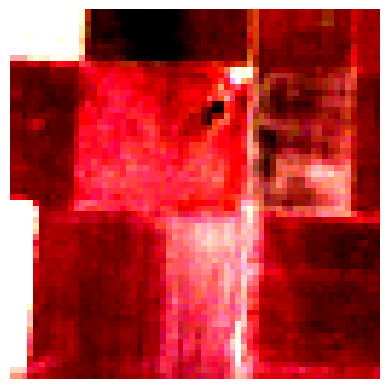

In [9]:
import matplotlib.pyplot as plt

img_np = trainSet[0][0].permute(1, 2, 0).cpu().numpy()
plt.imshow(img_np)
plt.axis("off")
plt.show()

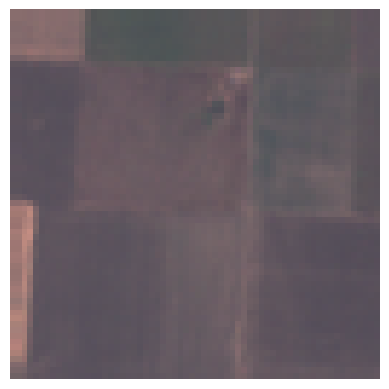

In [10]:
import matplotlib.pyplot as plt

img_np = ds["train"][0]["image"]
plt.imshow(img_np)
plt.axis("off") 
plt.show()

## Trainer

In [ ]:
def infer(model, device, testLoader):
    model.eval()
    predProba = []
    actual = []

    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            actual.append(labels)
            predProba.append(outputs)

    return torch.cat(predProba), torch.cat(actual)

In [33]:
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau


def train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    n_epochs=100,
    earlyStopping=10,
):
    optimScheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.2)

    # Training loop
    earlyStopping = 10
    bestValLoss = float("inf")
    bestModelState = None
    patience = 0

    trainLosses = []
    valLosses = []

    for epoch in range(n_epochs):
        trainLoss = 0
        trainAcc = 0
        model.train()

        for batch_idx, (inputs, labels) in enumerate(trainLoader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels).float().mean()

            loss.backward()
            optimizer.step()

            trainLoss += loss.item()
            trainAcc += acc.item()

            # Print every 100 batches
            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx}/{len(trainLoader)}], Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}"
                )

        trainLoss /= len(trainLoader)
        trainAcc /= len(trainLoader)
        trainLosses.append(trainLoss)

        # Validation loss
        pred, actual = infer(model, device, valLoader)
        valLoss = criterion(pred, actual)
        valAcc = (torch.argmax(pred, dim=1) == actual).float().mean()

        valLosses.append(valLoss)

        print(
            f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {trainLoss:.4f}, Val Loss: {valLoss:.4f}, Train Acc: {trainAcc:.4f}, Val Acc: {valAcc:.4f}"
        )
        print("=" * 50)

        # Early stopping
        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestModelState = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1
            if patience > earlyStopping:
                break

        optimScheduler.step(valLoss)

    # Save the model
    # torch.save(bestModelState, "model.pth")
    model.load_state_dict(bestModelState)  # type: ignore

## Model

In [13]:
from torch import nn
from torch.nn import functional as F


## TODO: move mobile net small here 
from mobilenet import CustomMobileNetSmall

## Training Loop

In [36]:
import torch.optim as optim


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# model = SimpleCnn().to(device)
model = CustomMobileNetSmall(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100

train(model, device, trainLoader, valLoader, criterion, optimizer, 100, 10)


Using device: cpu
Epoch [1/100], Step [0/254], Loss: 2.3054, Accuracy: 0.0938
Epoch [1/100], Step [100/254], Loss: 1.0382, Accuracy: 0.5625
Epoch [1/100], Step [200/254], Loss: 0.9147, Accuracy: 0.6406
Epoch [1/100], Train Loss: 1.1870, Val Loss: 2.7626, Train Acc: 0.5636, Val Acc: 0.0901
Epoch [2/100], Step [0/254], Loss: 0.8703, Accuracy: 0.6719
Epoch [2/100], Step [100/254], Loss: 0.7466, Accuracy: 0.7344
Epoch [2/100], Step [200/254], Loss: 0.9238, Accuracy: 0.6875
Epoch [2/100], Train Loss: 0.8228, Val Loss: 0.9357, Train Acc: 0.7127, Val Acc: 0.6570
Epoch [3/100], Step [0/254], Loss: 0.6997, Accuracy: 0.7344


KeyboardInterrupt: 

In [27]:
y.dtype

torch.float32